# Predicting and Visualizing Baseball Strike Zones With Machine Learning: Support Vector Machines

In Major League Baseball (MLB), the **strike zone** is a critical component of the game. It determines whether a pitch is called a **strike** or a **ball**. While the strike zone has a strict rulebook definition, in practice, its boundaries can vary based on the **batter's height**, the **umpire's judgment**, and other contextual factors.

In this project, we use **machine learning**—specifically **Support Vector Machines (SVMs)**—to analyze and visualize the "real strike zones" of three notable MLB players:

1. **Aaron Judge**: One of the tallest players in MLB history.  
2. **Jose Altuve**: One of the shortest players in MLB history.  
3. **David Ortiz**: A legendary power hitter with a unique approach to pitches.  

---

## Objective

The goal of this project is to:
1. Analyze pitch data for these players using **SVM classifiers** to identify decision boundaries that separate strikes and balls.
2. Visualize the **predicted strike zone** for each player based on pitch location (`plate_x` and `plate_z`).
3. Compare how the strike zones vary for players of different **physical builds**.

---

## Tools and Techniques

- **Python** for data analysis and machine learning.
- **Libraries**:
   - `pybaseball` for fetching MLB pitch data.
   - `matplotlib` for visualizing the scatter plots and decision boundaries.
   - `scikit-learn` for building and training the SVM classifiers.
- **Key Concepts**:
   - **Feature Engineering**: Using `plate_x` (horizontal pitch location) and `plate_z` (vertical pitch location) as features.
   - **SVM Decision Boundaries**: Visualizing the "real" strike zone where pitches are classified as strikes (`1`) or balls (`0`).
   - **Model Tuning**: Optimizing the SVM parameters (`C` and `gamma`) to achieve the best accuracy.

---

## Insights

By comparing the strike zones of **Aaron Judge**, **Jose Altuve**, and **David Ortiz**, we gain valuable insights into:
- How a batter’s **height** impacts the strike zone.
- How umpires' judgments and players' swing tendencies influence pitch outcomes.

This project combines **sports analytics**, **machine learning**, and **data visualization** to provide a unique perspective on one of baseball's most fundamental components: **the strike zone**.



In [1]:
import pybaseball as pb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from svm_visualization import draw_boundary



In [2]:
# Import the modules necessary to download our players stats
from pybaseball import  playerid_lookup
from pybaseball import  statcast_batter


aaron_judge_df = playerid_lookup('judge', 'aaron')
if not aaron_judge_df.empty:
    aaron_judge_id = aaron_judge_df.iloc[0]['key_mlbam']
else:
    raise ValueError("Aaron Judge not found in player lookup!")

jose_altuve_df = playerid_lookup('altuve', 'josé')
if not jose_altuve_df.empty:
    jose_altuve_id = jose_altuve_df.iloc[0]['key_mlbam']
else:
    raise ValueError("Jose Altuve not found in player lookup!")

david_ortiz_df = playerid_lookup('ortiz', 'david')
if not david_ortiz_df.empty:
    david_ortiz_id = david_ortiz_df.iloc[0]['key_mlbam']
else:
    raise ValueError("David Ortiz not found in player lookup!")

# Define the time range for stats
start_date = '2017-01-01'
end_date = '2017-12-31'

# Fetch stats for players
aaron_judge_stats = statcast_batter(start_date, end_date, aaron_judge_id)
jose_altuve_stats = statcast_batter(start_date, end_date, jose_altuve_id)
david_ortiz_stats = statcast_batter(start_date, end_date, david_ortiz_id)

#aaron_judge_stats.to_csv('aaron_judge_stats.csv', index=False)
#jose_altuve_stats.to_csv('jose_altuve_stats.csv', index=False)
#david_ortiz_stats.to_csv('david_ortiz_stats.csv', index=False)

# Step 5: View the DataFrame columns
print(aaron_judge_stats.columns)


Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Gathering Player Data
Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat',
       'pitcher_days_since_prev_game', 'batter_days_since_prev_game',
       'pitcher_days_until_next_game', 'batter_days_until_next_game',
       'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in',
       'arm_angle'],
      dtype='object', length=113)


In [3]:
# Understanding the data
# Check the unique values of the description column
print(aaron_judge_stats['description'].unique())

# Check the unique values of the type column
print(aaron_judge_stats['type'].unique()) # S: Represents a strike, B: Represents a ball, X: Represents a ball put into play (e.g., hit, ground out, fly out, etc.)
print(aaron_judge_stats['type'])

['swinging_strike' 'hit_into_play' 'foul' 'ball' 'blocked_ball'
 'called_strike' 'foul_tip' 'swinging_strike_blocked' 'hit_by_pitch']
['S' 'X' 'B']
0       S
1       S
2       S
3       X
4       X
       ..
3386    X
3387    S
3388    S
3389    X
3390    S
Name: type, Length: 3391, dtype: object


In [4]:
# Players 'type' mapping as follows: 'S' to 1, 'B' to 0
# Aaron Judge
aaron_judge_stats['type'] = aaron_judge_stats['type'].map({'S': 1, 'B': 0})
#print(aaron_judge_stats['type'])

# Jose Altuve
jose_altuve_stats['type'] = jose_altuve_stats['type'].map({'S': 1, 'B': 0})
print(jose_altuve_stats['type'])

# David Ortiz
david_ortiz_stats['type'] = david_ortiz_stats['type'].map({'S': 1, 'B': 0})
# print(david_ortiz_stats['type']) # EMPTY SERIE - maybe there aren't stats for David Ortiz on 2017?


0       NaN
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
2649    NaN
2650    0.0
2651    0.0
2652    0.0
2653    NaN
Name: type, Length: 2654, dtype: float64


In [5]:
# Preview both plate_x and plate_z columns
print(aaron_judge_stats[['plate_x', 'plate_z']].head())
print(jose_altuve_stats[['plate_x', 'plate_z']].head())
print(david_ortiz_stats[['plate_x', 'plate_z']].head())


   plate_x  plate_z
0     0.38     0.78
1     0.46     1.11
2     0.63     0.80
3     0.26     1.82
4     0.34     2.37
   plate_x  plate_z
0    -0.71     2.81
1    -0.66     1.58
2     1.08     2.26
3     0.72     3.44
4    -1.04     3.36
Empty DataFrame
Columns: [plate_x, plate_z]
Index: []


In [6]:
# Drop rows with NaN values in plate_x, plate_z, and type columns
aaron_judge_stats = aaron_judge_stats.dropna(subset=['plate_x', 'plate_z', 'type'])
jose_altuve_stats = jose_altuve_stats.dropna(subset=['plate_x', 'plate_z', 'type'])
david_ortiz_stats = david_ortiz_stats.dropna(subset=['plate_x', 'plate_z', 'type'])

# Verify that no NaN values remain in the specified columns
print("Aaron Judge NaN check:")
print(aaron_judge_stats[['plate_x', 'plate_z', 'type']].isna().sum())

print("Jose Altuve NaN check:")
print(jose_altuve_stats[['plate_x', 'plate_z', 'type']].isna().sum())

print("David Ortiz NaN check:")
print(david_ortiz_stats[['plate_x', 'plate_z', 'type']].isna().sum())


Aaron Judge NaN check:
plate_x    0
plate_z    0
type       0
dtype: int64
Jose Altuve NaN check:
plate_x    0
plate_z    0
type       0
dtype: int64
David Ortiz NaN check:
plate_x    0
plate_z    0
type       0
dtype: int64


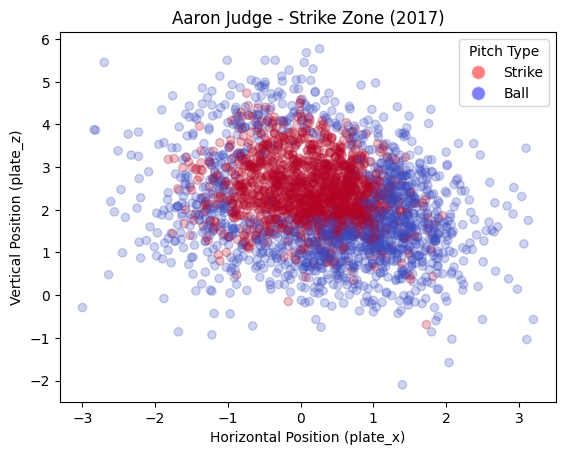

In [7]:
# Scatter plot for Aaron Judge's pitches
scatter = plt.scatter(
    x=aaron_judge_stats['plate_x'],  # Horizontal position
    y=aaron_judge_stats['plate_z'],  # Vertical position
    c=aaron_judge_stats['type'],     # Color by type (ball or strike)
    cmap=plt.cm.coolwarm,            # Color map: red for strikes, blue for balls
    alpha=0.25                       # Transparency
)

# Add labels and title
plt.xlabel('Horizontal Position (plate_x)')
plt.ylabel('Vertical Position (plate_z)')
plt.title('Aaron Judge - Strike Zone (2017)')

# Add a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=0.5, markersize=10, label='Strike'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.5, markersize=10, label='Ball')
]
plt.legend(handles=handles, title="Pitch Type")

# Show the plot
plt.show()


In [8]:
plt.clf()

<Figure size 640x480 with 0 Axes>

Classifier has been trained.


/Users/davidalmagro/Documents/projects/ml_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


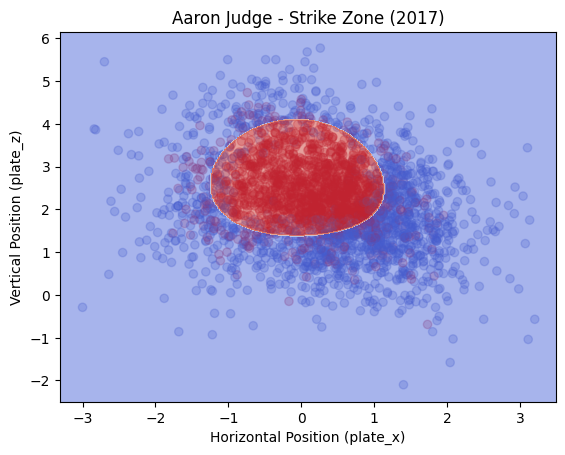

Classifier accuracy on the validation set: 82.82%


In [9]:
# Scatter plot for Aaron Judge's pitches
scatter = plt.scatter(
    x=aaron_judge_stats['plate_x'],  # Horizontal position
    y=aaron_judge_stats['plate_z'],  # Vertical position
    c=aaron_judge_stats['type'],     # Color by type (ball or strike)
    cmap=plt.cm.coolwarm,            # Color map: red for strikes, blue for balls
    alpha=0.25                       # Transparency
)

# Add labels and title
plt.xlabel('Horizontal Position (plate_x)')
plt.ylabel('Vertical Position (plate_z)')
plt.title('Aaron Judge - Strike Zone (2017)')


# Define the features and labels
features = aaron_judge_stats[['plate_x', 'plate_z']]  # Features: pitch location
labels = aaron_judge_stats['type']                   # Labels: ball (0) or strike (1)

# Split the data into training and validation sets
training_set, validation_set = train_test_split(
    aaron_judge_stats,  # Input data
    test_size=0.2,      # Reserve 20% of the data for validation
    random_state=1      # Ensure reproducibility
)
# Create an SVM classifier with an RBF kernel
classifier = SVC(kernel='rbf') # The default parameters for this classifier are C=1 and gamma='scale'

# Extract features (plate_x and plate_z) and labels (type) from the training set
training_features = training_set[['plate_x', 'plate_z']]
training_labels = training_set['type']

# Train the SVM classifier
classifier.fit(training_features, training_labels)

# Confirm the classifier has been trained
print("Classifier has been trained.")

# Add the decision boundary
draw_boundary(plt.gca(), classifier)

# Show the plot
plt.show()

# Extract features (plate_x and plate_z) and labels (type) from the validation set
validation_features = validation_set[['plate_x', 'plate_z']]
validation_labels = validation_set['type']

# Calculate and print the accuracy of the classifier
accuracy = classifier.score(validation_features, validation_labels)
print(f"Classifier accuracy on the validation set: {accuracy*100:.2f}%")


In [10]:
# Range of values to test for C and gamma
C_values = np.logspace(-2, 2, 5)  # [0.01, 0.1, 1, 10, 100]
gamma_values = np.logspace(-2, 2, 5)  # [0.01, 0.1, 1, 10, 100]

# Initialize variables to track the best configuration
best_accuracy = 0
best_C = None
best_gamma = None

# Loop through all combinations of C and gamma
for C in C_values:
    for gamma in gamma_values:
        # Create an SVM classifier with the current C and gamma
        classifier = SVC(kernel='rbf', C=C, gamma=gamma)
        
        # Train the classifier on the training set
        classifier.fit(training_features, training_labels)
        
        # Evaluate the classifier on the validation set
        accuracy = classifier.score(validation_features, validation_labels)
        
        # Print the configuration and accuracy
        print(f"C: {C:.2f}, Gamma: {gamma:.2f}, Accuracy: {accuracy*100:.4f}%")
        
        # Update the best configuration if this one is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_gamma = gamma

# Print the best configuration and its accuracy
print(f"Best configuration -> C: {best_C:.2f}, Gamma: {best_gamma:.2f}, Accuracy: {best_accuracy*100:.4f}%")

C: 0.01, Gamma: 0.01, Accuracy: 50.6873%
C: 0.01, Gamma: 0.10, Accuracy: 71.8213%
C: 0.01, Gamma: 1.00, Accuracy: 82.6460%
C: 0.01, Gamma: 10.00, Accuracy: 65.8076%
C: 0.01, Gamma: 100.00, Accuracy: 50.6873%
C: 0.10, Gamma: 0.01, Accuracy: 73.3677%
C: 0.10, Gamma: 0.10, Accuracy: 81.6151%
C: 0.10, Gamma: 1.00, Accuracy: 82.8179%
C: 0.10, Gamma: 10.00, Accuracy: 83.1615%
C: 0.10, Gamma: 100.00, Accuracy: 77.1478%
C: 1.00, Gamma: 0.01, Accuracy: 73.5395%
C: 1.00, Gamma: 0.10, Accuracy: 82.3024%
C: 1.00, Gamma: 1.00, Accuracy: 83.1615%
C: 1.00, Gamma: 10.00, Accuracy: 83.3333%
C: 1.00, Gamma: 100.00, Accuracy: 82.6460%
C: 10.00, Gamma: 0.01, Accuracy: 80.5842%
C: 10.00, Gamma: 0.10, Accuracy: 82.9897%
C: 10.00, Gamma: 1.00, Accuracy: 82.6460%
C: 10.00, Gamma: 10.00, Accuracy: 82.8179%
C: 10.00, Gamma: 100.00, Accuracy: 79.0378%
C: 100.00, Gamma: 0.01, Accuracy: 81.4433%
C: 100.00, Gamma: 0.10, Accuracy: 82.8179%
C: 100.00, Gamma: 1.00, Accuracy: 82.9897%
C: 100.00, Gamma: 10.00, Accuracy:

/Users/davidalmagro/Documents/projects/ml_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


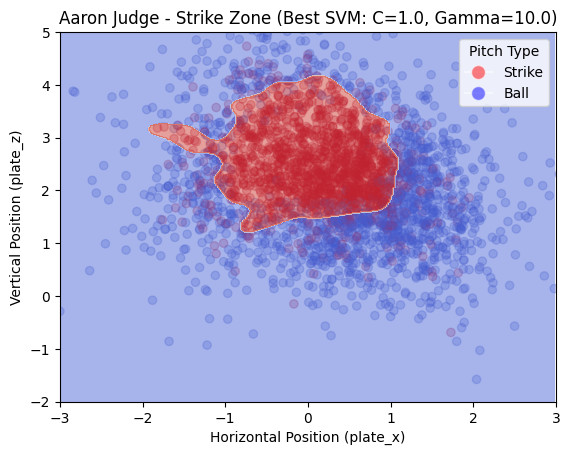

In [11]:
# Create and train the SVM with the best parameters
best_classifier = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
best_classifier.fit(training_features, training_labels)

# Plot the scatter plot with the decision boundary
fig, ax = plt.subplots()

# Scatter plot for Aaron Judge's pitches
scatter = ax.scatter(
    x=aaron_judge_stats['plate_x'],  # Horizontal position
    y=aaron_judge_stats['plate_z'],  # Vertical position
    c=aaron_judge_stats['type'],     # Color by type (ball or strike)
    cmap=plt.cm.coolwarm,            # Color map: red for strikes, blue for balls
    alpha=0.25                       # Transparency
)

# Set the axes limits for better visualization
ax.set_xlim(-3, 3)
ax.set_ylim(-2, 5)

# Add labels and title
ax.set_xlabel('Horizontal Position (plate_x)')
ax.set_ylabel('Vertical Position (plate_z)')
ax.set_title(f'Aaron Judge - Strike Zone (Best SVM: C={best_C}, Gamma={best_gamma})')

# Add the decision boundary
draw_boundary(ax, best_classifier)

# Add a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=0.5, markersize=10, label='Strike'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.5, markersize=10, label='Ball')
]
ax.legend(handles=handles, title="Pitch Type")

# Show the plot
plt.show()

In [12]:
# Define the function
def visualize_strike_zone(data, player_name, C=1.0, gamma=10.0):
    # Define features and labels
    features = data[['plate_x', 'plate_z']]
    labels = data['type']

    # Split the data into training and validation sets
    training_set, validation_set = train_test_split(data, test_size=0.2, random_state=1)

    # Extract features and labels for training
    training_features = training_set[['plate_x', 'plate_z']]
    training_labels = training_set['type']

    # Train the SVM with the best parameters
    classifier = SVC(kernel='rbf', C=C, gamma=gamma)
    classifier.fit(training_features, training_labels)

    # Plot the scatter plot with the decision boundary
    fig, ax = plt.subplots()

    # Scatter plot
    scatter = ax.scatter(
        x=data['plate_x'],
        y=data['plate_z'],
        c=data['type'],
        cmap=plt.cm.coolwarm,
        alpha=0.25
    )

    # Add labels and title
    ax.set_xlabel('Horizontal Position (plate_x)')
    ax.set_ylabel('Vertical Position (plate_z)')
    ax.set_title(f"{player_name} - Strike Zone (C={C}, Gamma={gamma})")

    # Set consistent axes limits for comparison
    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 6)

    # Add the decision boundary
    draw_boundary(ax, classifier)

    # Add a custom legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=0.5, markersize=10, label='Strike'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.5, markersize=10, label='Ball')
    ]
    ax.legend(handles=handles, title="Pitch Type")

    # Show the plot
    plt.show()

/Users/davidalmagro/Documents/projects/ml_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


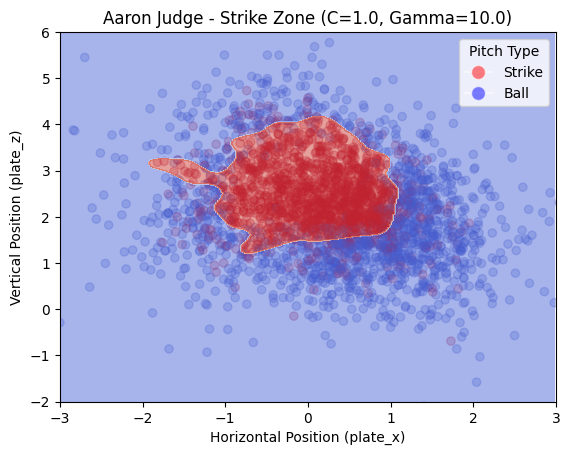

In [13]:
# Visualize strike zones for Aaron Judge
visualize_strike_zone(aaron_judge_stats, "Aaron Judge", C=1.0, gamma=10.0)

/Users/davidalmagro/Documents/projects/ml_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

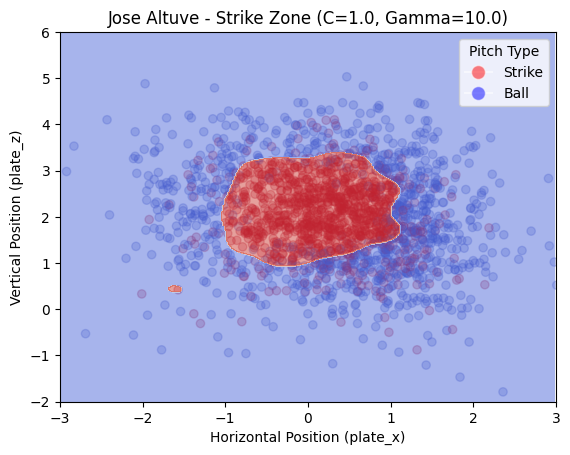

In [14]:
# Visualize strike zones for Jose Altuve
plt.clf()
visualize_strike_zone(jose_altuve_stats, "Jose Altuve", C=1.0, gamma=10.0)

In [15]:
# Visualize strike zones for David Ortiz

plt.clf()
#visualize_strike_zone(david_ortiz_stats, "David Ortiz", C=1.0, gamma=10.0)

<Figure size 640x480 with 0 Axes>